# Import Libraries 

In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from lightgbm import LGBMClassifier, early_stopping
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from datetime import datetime
from optuna.samplers import TPESampler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from collections import Counter
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Load Train and Test Datasets

In [4]:
# Load training and test datasets
train_df = pd.read_csv("C:/Users/SHARON/Downloads/Train.csv")
test_df = pd.read_csv("C:/Users/SHARON/Downloads/Test.csv")
train_df.head()

,FarmID,category,Crop,State,District,Sub-District,SDate,HDate,CropCoveredArea,CHeight,CNext,CLast,CTransp,IrriType,IrriSource,IrriCount,WaterCov,ExpYield,Season,geometry
0,1326576,Healthy,Paddy,Telangana,Medak,Kulcharam,2023-11-25 0:00:00,2024-04-14 0:00:00,97,54,Pea,Lentil,Transplanting,Flood,Groundwater,4,87,17,Rabi,POLYGON ((78.18143246076087 17.978884603571068...
1,1326577,Healthy,Paddy,Telangana,Medak,Kulcharam,2023-11-13 0:00:00,2024-04-26 0:00:00,82,58,Pea,Lentil,Transplanting,Flood,Canal,5,94,15,Rabi,POLYGON ((78.17545177547453 17.981074445477304...
2,1326578,Healthy,Paddy,Telangana,Medak,Kulcharam,2023-12-19 0:00:00,2024-04-28 0:00:00,92,91,Pea,Lentil,Transplanting,Flood,Canal,3,99,20,Rabi,POLYGON ((78.16914224770792 17.976212849967755...
3,1331836,Diseased,Paddy,Telangana,Medak,Kulcharam,2023-02-11 0:00:00,2024-11-04 0:00:00,91,52,Pea,Lentil,Transplanting,Flood,Canal,5,92,16,Rabi,POLYGON ((78.16889103841902 17.974608186550842...
4,1326579,Diseased,Paddy,Telangana,Medak,Kulcharam,2023-12-12 0:00:00,2024-05-19 0:00:00,94,55,Pea,Lentil,Transplanting,Flood,Canal,5,97,20,Rabi,POLYGON ((78.17264452998072 17.969251496349454...


# Combine Train and Test Data for Encoding and Define Features


In [6]:
# Combine train and test data for encoding
combined_df = pd.concat([train_df, test_df], axis=0)

# Categorical columns to be encoded
categorical_cols = ['Crop', 'State', 'District', 'Sub-District', 'CNext', 'CLast', 'CTransp', 'IrriType', 'IrriSource', 'Season']
target_col = 'category'

# 1. Convert categorical columns to numerical values using LabelEncoder
label_encoder = LabelEncoder()

# Ensure that all categorical columns are properly encoded in the combined DataFrame
for col in categorical_cols:
    combined_df[col] = label_encoder.fit_transform(combined_df[col])

# Split the combined DataFrame back into train and test sets
train_df[categorical_cols] = combined_df[categorical_cols].iloc[:len(train_df)]
test_df[categorical_cols] = combined_df[categorical_cols].iloc[len(train_df):]

# 2. Define features (X) and target (y) for training
X_train = train_df[categorical_cols]
y_train = train_df[target_col]

# Check if all categorical columns are now numeric
print(X_train.dtypes)


Crop            int32
State           int32
District        int32
Sub-District    int32
CNext           int32
CLast           int32
CTransp         int32
IrriType        int32
IrriSource      int32
Season          int32
dtype: object


# Data Cleaning 

In [8]:
# Drop 'SDate' and 'HDate' columns from both train_df and test_df
train_df = train_df.drop(['SDate', 'HDate'], axis=1)
test_df = test_df.drop(['SDate', 'HDate'], axis=1)

# Optionally, you can confirm by printing the updated DataFrame to check
print(train_df.head())
print(test_df.head())

    FarmID  category  Crop  State  District  Sub-District  CropCoveredArea  \
0  1326576   Healthy     5      0         6            75               97   
1  1326577   Healthy     5      0         6            75               82   
2  1326578   Healthy     5      0         6            75               92   
3  1331836  Diseased     5      0         6            75               91   
4  1326579  Diseased     5      0         6            75               94   

   CHeight  CNext  CLast  CTransp  IrriType  IrriSource  IrriCount  WaterCov  \
0       54      4      0        3         1           1          4        87   
1       58      4      0        3         1           0          5        94   
2       91      4      0        3         1           0          3        99   
3       52      4      0        3         1           0          5        92   
4       55      4      0        3         1           0          5        97   

   ExpYield  Season                               

In [9]:
#checking null values 
train_df.isnull().sum()

FarmID             0
category           0
Crop               0
State              0
District           0
Sub-District       0
CropCoveredArea    0
CHeight            0
CNext              0
CLast              0
CTransp            0
IrriType           0
IrriSource         0
IrriCount          0
WaterCov           0
ExpYield           0
Season             0
geometry           0
dtype: int64

In [10]:
train_df.shape
test_df.shape

(2718, 17)

In [11]:
train_df['category'].value_counts()

category
Healthy     6506
Pests        485
Diseased     474
Stressed     423
Name: count, dtype: int64

# Feature and Target Separation for Model Training and Testing

In [13]:
# Drop 'category' from X_train and 'geometry' from both X_train and X_test
X_train = train_df.drop(['category', 'geometry'], axis=1)
y_train = train_df['category']
X_test = test_df.drop(['geometry'], axis=1)

# Check if the features are consistent
print(X_train.head())
print(X_test.head())

    FarmID  Crop  State  District  Sub-District  CropCoveredArea  CHeight  \
0  1326576     5      0         6            75               97       54   
1  1326577     5      0         6            75               82       58   
2  1326578     5      0         6            75               92       91   
3  1331836     5      0         6            75               91       52   
4  1326579     5      0         6            75               94       55   

   CNext  CLast  CTransp  IrriType  IrriSource  IrriCount  WaterCov  ExpYield  \
0      4      0        3         1           1          4        87        17   
1      4      0        3         1           0          5        94        15   
2      4      0        3         1           0          3        99        20   
3      4      0        3         1           0          5        92        16   
4      4      0        3         1           0          5        97        20   

   Season  
0       1  
1       1  
2       1  
3 

# Preprocessing and Training with LightGBM and Stacking Model

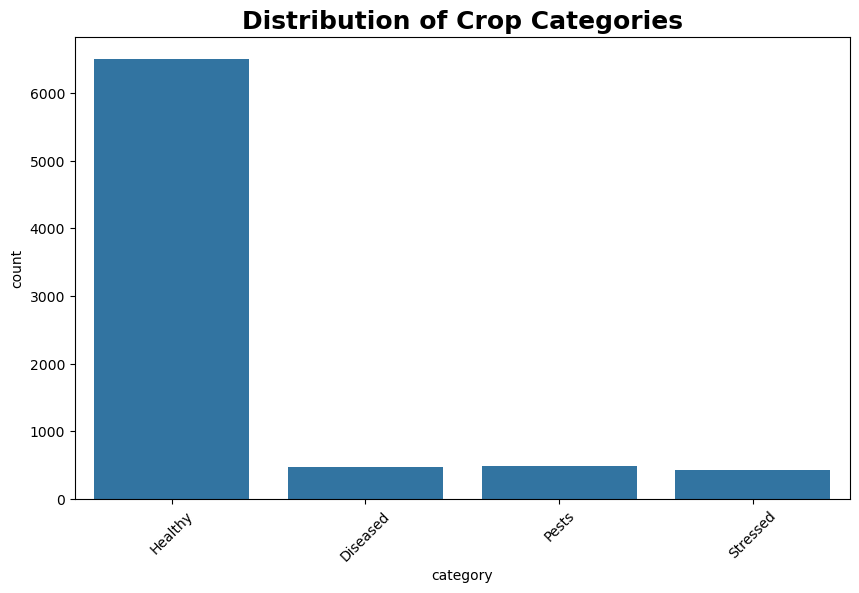

In [15]:
# Create a countplot for the 'Crop' column
plt.figure(figsize=(10,6))  # Adjust the figure size for better readability
sns.countplot(x='category', data=train_df)  # 'Crop' is the column you want to plot

# Optionally, you can rotate the x-axis labels if they are long
plt.xticks(rotation=45)  # Rotate labels to make them more readable if needed
# Add a title to the plot
plt.title('Distribution of Crop Categories', fontsize=18, fontweight='bold')

# Display the plot
plt.show()


In [16]:
# List of categorical columns
categorical_cols = ['Crop', 'State', 'District', 'Sub-District', 'CNext', 'CLast', 'CTransp', 'IrriType', 'IrriSource', 'Season']

# Verify that the DataFrame contains these columns
missing_cols = [col for col in categorical_cols if col not in X_train.columns]
if missing_cols:
    raise ValueError(f"Columns {missing_cols} not found in the DataFrame")

# Ensure categorical columns are of type 'category'
for col in categorical_cols:
    if X_train[col].dtype != 'category':
        X_train[col] = X_train[col].astype('category')
    if X_test[col].dtype != 'category':
        X_test[col] = X_test[col].astype('category')

# Encode the target labels if not already encoded
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Compute class weights based on inverse of class frequencies
class_counts = Counter(y_train_encoded)
class_weights = {cls: 1.0/count for cls, count in class_counts.items()}

# Define the base LightGBM model with early stopping and callback
base_lgb_model = lgb.LGBMClassifier(
    n_estimators=1500,
    learning_rate=0.05,
    max_depth=8,
    random_state=42,
    n_jobs=-1,
    num_leaves=31,
    min_child_samples=20,
    class_weight=class_weights,  # Custom class weights
    categorical_feature=categorical_cols)

# Define the meta-model for stacking (Random Forest)
meta_rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'  # Automatically handles class imbalance
)

# StackingClassifier: Use LightGBM as the base model and Random Forest as the meta-model
stacking_model = StackingClassifier(
    estimators=[('base_lgb', base_lgb_model)],  # Base model (LightGBM)
    final_estimator=meta_rf_model,  # Meta-model (Random Forest)
    cv=3  # Cross-validation for the meta-model
)

# Create StratifiedKFold cross-validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store F1 and Accuracy scores for each fold
f1_scores_list = []
accuracy_scores_list = []

# Cross-validation loop
for train_idx, val_idx in skf.split(X_train, y_train_encoded):
    # Split the data into training and validation sets
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train_encoded[train_idx], y_train_encoded[val_idx]

    # Define eval_set for early stopping
    evals = [(X_val_fold, y_val_fold)]  # Validation set for early stopping
    
    # Train the base LightGBM model with early stopping using callback
    base_lgb_model.fit(
        X_train_fold, y_train_fold,
        eval_set=evals,
        eval_metric='multi_logloss',  # Evaluation metric
        callbacks=[lgb.early_stopping(stopping_rounds=50)]
    )

    # After training with early stopping, use the best iteration from the booster
    best_iter = base_lgb_model.best_iteration_
    print(f"Best iteration: {best_iter}")

    # Predict on the validation set using the best iteration
    y_pred = base_lgb_model.predict(X_val_fold, num_iteration=best_iter)

    # Evaluate the model using F1 score and accuracy
    f1_scores_list.append(f1_score(y_val_fold, y_pred, average='weighted'))
    accuracy_scores_list.append(accuracy_score(y_val_fold, y_pred))

    # Print classification report for this fold
    print(f"Classification Report for fold:")
    print(classification_report(y_val_fold, y_pred))

# Calculate and print average F1 score and accuracy across all folds
avg_f1_score = np.mean(f1_scores_list)
avg_accuracy_score = np.mean(accuracy_scores_list)
print(f"Stacking Average F1 Score: {avg_f1_score:.4f}")
print(f"Stacking Average Accuracy Score: {avg_accuracy_score:.4f}")

# Train the final stacking model on the entire dataset
stacking_model.fit(X_train, y_train_encoded)

# Predict on the test data
test_predictions = stacking_model.predict(X_test)

# Decode the predictions back to original labels
test_predictions = label_encoder.inverse_transform(test_predictions)

# Print the number of predictions and rows in the test DataFrame
print(f"Number of test predictions: {len(test_predictions)}")
print(f"Number of rows in test_df: {len(X_test)}")


[LightGBM] [Warning] categorical_feature is set=Crop,State,District,Sub-District,CNext,CLast,CTransp,IrriType,IrriSource,Season, categorical_column=1,2,3,4,7,8,9,10,11,15 will be ignored. Current value: categorical_feature=Crop,State,District,Sub-District,CNext,CLast,CTransp,IrriType,IrriSource,Season
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 817
[LightGBM] [Info] Number of data points in the train set: 6310, number of used features: 15
[LightGBM] [Info] Start training from score -1.384380
[LightGBM] [Info] Start training from score -1.386642
[LightGBM] [Info] Start training from score -1.386488
[LightGBM] [Info] Start training from score -1.387671
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain:

# Flatten Predictions and Verify Shape


In [18]:
# Flatten the predictions to a 1D array
test_predictions = test_predictions.flatten()  # or test_predictions = test_predictions.ravel()

# Now check the shape again
print("Shape of test_predictions after flattening:", test_predictions.shape)

# Ensure the length of test_predictions matches the rows in submission_df or test_df
print(f"Length of test_predictions: {len(test_predictions)}")

Shape of test_predictions after flattening: (2718,)
Length of test_predictions: 2718


# Save Predictions to Submission CSV


In [20]:
#save in submission csv
submission_df = test_df[['FarmID']].copy()  # Keep 'farmid' for submission
submission_df['Target'] = test_predictions
print(f"Number of rows in submission_df: {submission_df.shape[0]}")

Number of rows in submission_df: 2718


In [21]:
#Save the results to a CSV file 
submission_df.to_csv('submission.csv', index=False)

print("Submission file 'submission.csv' created successfully.")

Submission file 'submission.csv' created successfully.
